In [99]:
from futu import *
import datetime as dt
import pandas as pd


quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111) 
ticker = "0981"
# today_end = dt.datetime.now().replace(hour=16, minute=0, second=0, microsecond=0) 
# today_start = today_end.replace(hour=9, minute=30)

#cur_end, cur_start = today_end-dt.timedelta(days=1), today_start-dt.timedelta(days=1)
end = dt.date.today()
ret, df, page_req_key = quote_ctx.request_history_kline('HK.0'+ticker, 
                                                        start=str(end-dt.timedelta(days=365)), 
                                                        end= str(end), 
                                                        max_count= None, 
                                                        fields=[KL_FIELD.DATE_TIME,
                                                                KL_FIELD.OPEN,
                                                                KL_FIELD.HIGH,
                                                                KL_FIELD.LOW,
                                                                KL_FIELD.CLOSE,
                                                                KL_FIELD.TRADE_VOL])
if ret !=RET_OK:
    print('error: ', df)
else:
    df = df[df.columns[-6:]].rename(columns={"time_key":"date"})
    df["date"] = pd.to_datetime(df["date"]).dt.date
    print(df.head)


2025-11-03 15:33:35,147 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=15, host=127.0.0.1, port=11111, user_id=33457180


<bound method NDFrame.head of            date   open   high    low  close     volume
0    2024-11-04  25.80  26.15  25.65  25.85   82631120
1    2024-11-05  25.90  27.95  25.90  27.50  226572844
2    2024-11-06  27.40  28.40  26.55  26.90  196763392
3    2024-11-07  27.10  28.50  26.80  28.25  174937242
4    2024-11-08  29.80  30.30  28.55  28.55  297530223
..          ...    ...    ...    ...    ...        ...
241  2025-10-27  82.95  83.80  80.80  82.80  143794946
242  2025-10-28  82.80  85.50  80.05  80.10  124471245
243  2025-10-30  81.95  82.40  77.30  79.20  141883664
244  2025-10-31  79.20  79.20  74.60  75.00  108145564
245  2025-11-03  74.20  75.20  71.30  72.70   89598173

[246 rows x 6 columns]>


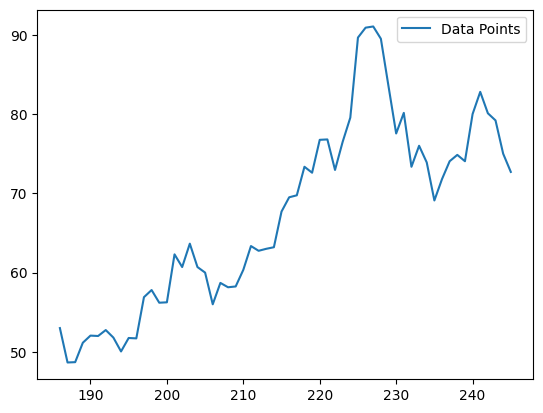

/var/folders/9x/bx7xlv0n3dng9qnrzlpnm52w0000gn/T/ipykernel_74536/1708861798.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x1, y1, 10)  # 1 for linear


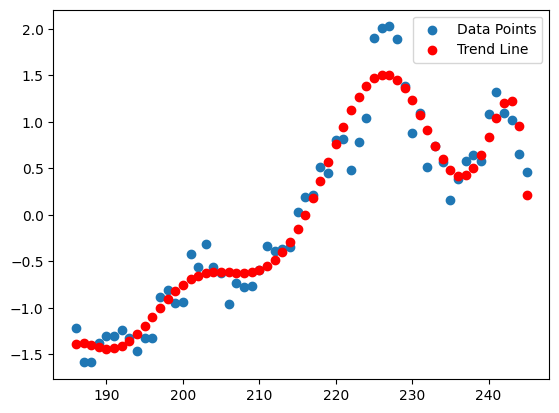

0.4540774636455089


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x= df.close.index.values
y= df.close.values.reshape(-1,1)


# Plotting
plt.plot(x[-60:], y[-60:], label='Data Points')
plt.legend()
plt.show()

#-------------------------------------
x1 = x[-60:]
y1 = scaler.fit_transform(y[-60:])
coefficients = np.polyfit(x1, y1, 10)  # 1 for linear
poly_fit = np.polyval(coefficients, x1)

# Plotting
plt.scatter(x1, y1, label='Data Points')
plt.plot(x1, poly_fit, color='red', label='Trend Line')
plt.legend()
plt.show()


print(np.sqrt(np.mean((y1[-10:] - poly_fit[-10:]) ** 2)))


2025-11-04 13:17:29,473 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=76, host=127.0.0.1, port=11111, user_id=33457180
刚刚呈现多头排列的日期：
Index([80, 156, 165, 232], dtype='int64')


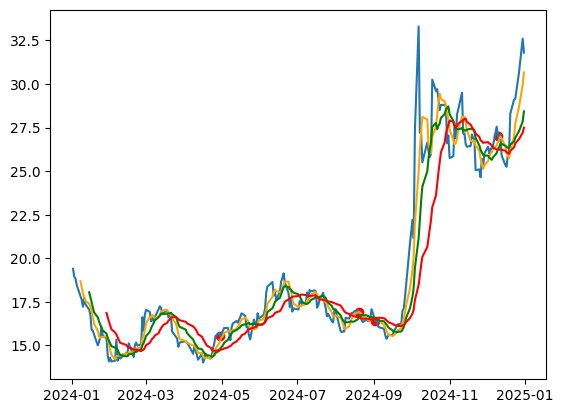

In [154]:
import pandas as pd
from futu import *
import numpy as np

# 获取历史数据
def fetch_data(ticker, start, end):
    quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111) 
    ret, df, page_req_key = quote_ctx.request_history_kline('HK.0'+ticker, 
                                                            start=str(start), 
                                                            end= str(end), 
                                                            max_count= None, 
                                                            fields=[KL_FIELD.DATE_TIME,
                                                                    KL_FIELD.OPEN,
                                                                    KL_FIELD.HIGH,
                                                                    KL_FIELD.LOW,
                                                                    KL_FIELD.CLOSE,
                                                                    KL_FIELD.TRADE_VOL])
    if ret !=RET_OK:
        print('error: ', df)
    else:
        df = df.rename(columns={"time_key":"date"})
        df["date"] = pd.to_datetime(df["date"]).dt.date
    return df

# 计算移动平均线
def calculate_moving_averages(data, short_window=5, medium_window=10, long_window=20):
    data['Short_MA'] = data['close'].rolling(window=short_window).mean()
    data['Medium_MA'] = data['close'].rolling(window=medium_window).mean()
    data['Long_MA'] = data['close'].rolling(window=long_window).mean()
    return data

# 检测刚刚呈现多头排列
def check_recent_bullish_alignment(data):
    data['Bullish'] = (data['Short_MA'] > data['Medium_MA']) & (data['Medium_MA'] > data['Long_MA'])
    
    # 检测刚刚形成多头排列
    data['Turn_Bullish'] = (data['Bullish']) & ((~data['Bullish']).shift(1))
    sel_data = data[data.Turn_Bullish]['close']
    data['Just_Bullish'] = False
    id = sel_data[sel_data < sel_data.shift(1)].index
    data.loc[id,'Just_Bullish'] = True
    return data

# 主程序
if __name__ == "__main__":
    # 获取数据
    symbol = '0981'
    start_date = '2024-01-01'
    end_date = '2025-01-01'
    data = fetch_data(symbol, start_date, end_date)

    # 计算移动平均线
    data = calculate_moving_averages(data)

    # 检测刚刚呈现多头排列
    data = check_recent_bullish_alignment(data)

    # 输出结果
    recent_bullish_days = data[data['Just_Bullish']]
    print("刚刚呈现多头排列的日期：")
    print(recent_bullish_days.index)

    import matplotlib.pyplot as plt
    plt.plot(data.date, data.close)
    plt.plot(data.date, data.Short_MA, color='orange')
    plt.plot(data.date, data.Medium_MA, color='green')
    plt.plot(data.date, data.Long_MA, color='red')
    plt.scatter(data.date[recent_bullish_days.index], data.close[recent_bullish_days.index], color='r')

In [131]:
tmp = data.iloc[recent_bullish_days.index]
tmp['pct_change'] = tmp.close/tmp.Long_MA-1
tmp

/var/folders/9x/bx7xlv0n3dng9qnrzlpnm52w0000gn/T/ipykernel_74536/1980908532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['pct_change'] = tmp.close/tmp.Long_MA-1


,code,date,open,high,low,close,volume,Short_MA,Medium_MA,Long_MA,Bullish,Just_Bullish,pct_change
35,HK.00288,2024-02-22,3.37327,3.44327,3.33327,3.43327,19443102,3.33127,3.26127,3.24627,1,1,0.057605
46,HK.00288,2024-03-08,3.42327,3.73327,3.42327,3.57327,31328383,3.38927,3.35827,3.31527,1,1,0.077822
61,HK.00288,2024-04-02,3.85327,3.95327,3.80327,3.92327,48085356,3.76727,3.75627,3.68527,1,1,0.064581
75,HK.00288,2024-04-23,4.11327,4.37327,4.08327,4.35327,46193671,4.05327,4.04527,3.91877,1,1,0.110877
89,HK.00288,2024-05-14,4.48327,4.53327,4.36327,4.49327,29909052,4.33127,4.31327,4.24077,1,1,0.059541
133,HK.00288,2024-07-18,4.10327,4.33327,4.10327,4.19327,22685752,4.12327,3.96927,3.96777,1,1,0.056833
152,HK.00288,2024-08-14,4.22327,4.51327,4.22327,4.49327,74569870,4.13927,4.03527,3.99877,1,1,0.123663
163,HK.00288,2024-08-29,4.34327,4.48327,4.29327,4.47327,13383104,4.40527,4.38427,4.24027,1,1,0.054949
203,HK.00288,2024-10-30,5.28327,5.34327,5.11327,5.28327,31300922,5.20527,5.11927,5.10777,1,1,0.034359
218,HK.00288,2024-11-20,5.24327,5.38327,5.23327,5.33327,24842529,5.16127,5.11627,5.09627,1,1,0.046505


In [118]:
data.head()

,code,date,open,high,low,close,volume,Short_MA,Medium_MA,Long_MA,Bullish,Just_Bullish
0,HK.00981,2022-01-03,18.80,18.92,18.66,18.84,6902187,NaN,NaN,NaN,0,0
1,HK.00981,2022-01-04,18.90,18.94,18.42,18.60,24126370,NaN,NaN,NaN,0,0
2,HK.00981,2022-01-05,18.70,18.70,18.02,18.18,32615272,NaN,NaN,NaN,0,0
3,HK.00981,2022-01-06,18.04,18.48,17.98,18.30,30370273,NaN,NaN,NaN,0,0
4,HK.00981,2022-01-07,18.16,18.50,18.10,18.18,22727035,18.42,NaN,NaN,0,0


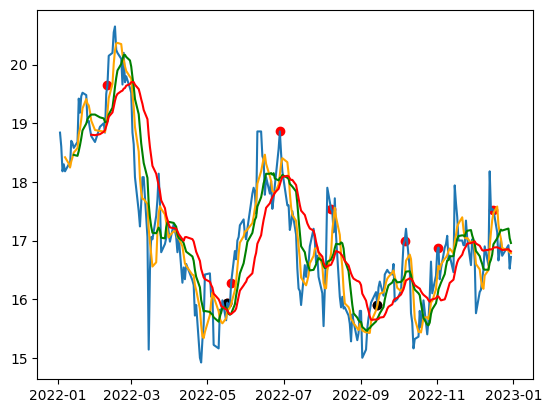

In [127]:
import matplotlib.pyplot as plt
plt.plot(data.date, data.close)
plt.plot(data.date, data.Short_MA, color='orange')
plt.plot(data.date, data.Medium_MA, color='green')
plt.plot(data.date, data.Long_MA, color='red')
plt.scatter(data.date[recent_bullish_days.index], data.close[recent_bullish_days.index], color='r')
plt.scatter(data.date[[88,171]],data.close[[88,171]],color='black')
plt.show()